# Stereovision

![Suzanne](main.png)

Stereovision is a discipline that deals with the reconstruction of 3D information from images. For the reconstruction of a point, several images of this point are needed. These images must be taken from different points of view. The key step of the reconstruction, which is often problematic, is to identify the images of the point to be reconstructed in each view.

## Epipolar Geometry

Epipolar geometry involves two cameras. The epipolar geometry describes the geometric properties between two views of the same scene and depends only on the intrinsic parameters of the cameras and their relative positions. It provides, in particular, the epipolar constraint, which will be very useful to produce the matches between views.

## The Fondamental Matrix

![Epipolar Geometry - Sanyam Kapoor](epipolar.png)

Let us imagine that we have two images, right and left, of the world space. Let's take a point $\vec{x}$ in the right image space. The point $\vec{X}$ of the world space, of which $\vec{x}$ is the image, can be anywhere on the line passing through $\vec{x}$ and the optical center of the right camera. We will call this line the back-projected ray of $\vec{x}$. Let us note $\vec{x}'$ the image of $\vec{X}$ in the left image space. The locus of $\vec{x}'$ is therefore the image line of the back-projected ray of $\vec{x}$. This line is called the epipolar line and is denoted $\vec{l}'$. The epipolar line passes through the epipole $\vec{e}'$, image of the optical center of the right camera.

In 2D projective geometry, a line with equation $ax+by+c = 0$ is represented by a vector with three components $(a, b, c)^T$ defined to within one factor. Thus, we have the following relationship:

>The point $\vec{x}$ belongs to the line $\vec{l}$ if and only if $x^T\vec{l} = 0$.

Moreover, in 2D projective geometry, the following remarkable relations are valid:

- The intersection of two lines $l$ and $l'$ is given by $x = l \times l'$,
- The line passing through two points $x$ and $x'$ is given by $l = x \times x'$.

Note that the vector product can be written as a product of matrix $x \times y = [x]_\times y$ where

$$[x]_\times = \begin{pmatrix} 0 & −x3 & x2 \\ x3 & 0 & −x1 \\ −x2 & x1 & 0 \end{pmatrix}$$

To find the equation of the epipolar line in the left image space, we just need to find the coordinates of two points of this line. The first is the image $P'\vec{C}$ of the optical center $\vec{C}$ of the right camera where $P'$ is the projection matrix of the left camera. The second is $P'P^{+}\vec{x}$ where $P^{+}$ is the pseudo inverse of the projection matrix $P$ of the right camera. The epipolar line thus has the equation $l' = [P'\vec{C}]_\times{}P'P^{+}\vec{x} = F\vec{x}$ with $F = [P'\vec{C}]_\times{}P'P^{+}$. $F$ is called fundamental matrix.

Since the epipolar line $\vec{l}' = F\vec{x}$ is the locus of $\vec{x}'$, $\vec{x}'$ therefore belongs to $\vec{l}'$ which leads to the epipolar constraint :

>**The fundamental matrix is such that for any pair of points corresponding $\vec{x} \leftrightarrow \vec{x}'$ in the two images, we have $\vec{x}'^{T}F\vec{x} = 0$.**

## Computation of the fundamental matrix

The fundamental matrix $F$ has seven degrees of freedom. It has nine components but these are defined to within one scale factor, which removes one degree of freedom. Moreover, the matrix $F$ is a singular matrix ($det(F) = 0$) which gives us seven degrees of freedom. So we need at least seven correspondences to compute $F$. The equation $x'^{T}_iFx_i = 0$ and the seven correspondences allow us to write a system of equations of the form $Af = 0$, where $f$ is the vector which contains the components of the matrix $F$. Let us assume that $A$ is a 7×9 matrix of rank 7. The general solution of $Af = 0$ can be written $\alpha f_1 + (1-\alpha) f_2$ where $f_1$ and $f_2$ are two particular independent solutions of $Af = 0$. We then use the singularity constraint $det(\alpha F_1 + (1 - \alpha)F_2) = 0$ to determine $\alpha$. Since the singularity constraint gives rise to a third degree equation, we may have one or three solutions for $F$.

## OpenCV

In practice you will use the OpenCV library. In python, you have access to its functions through the `cv2` module.

You can find help with the calibration and reconstruction functions on the site https://docs.opencv.org/4.0.0/d9/d0c/group__calib3d.html

## Goal

In the zip of the statement you will find two sequences of images taken by two cameras during the scanning of an object by a laser plane.

![Laser](scanRight/scan0010.png)

You will also find shots of a checkerboard in different positions that will help you calibrate your cameras.

![Damier](chessboards/c2Right.png)

The goal is to reconstruct the scanned object in 3D.

In [51]:
import numpy as np
import cv2 as cv
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mathutils import geometry as pygeo
from mathutils import Vector
import matplotlib.pyplot as plt

#Etape 1 
#Recuper les données de nos deux caméras

#Prepa
chessboardSize = (7,7)
imgSize = (1920,1080)

# termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((chessboardSize[0] * chessboardSize[1], 3), np.float32) 
objp[:,:2] = np.mgrid[0:chessboardSize[0], 0:chessboardSize[1]].T.reshape(-1,2)

#Tableau pour enrégistrer les points 3D et 2D
objpoints = [] 
imgpointsL = [] 
imgpointsR = [] 

imagesLeft = sorted(glob.glob('chessboards/c*L*.png'))
imagesRight = sorted(glob.glob('chessboards/c*R*.png'))

for imgLeft, imgRight in zip(imagesLeft, imagesRight):
    imgL = cv.imread(imgLeft)
    imgR = cv.imread(imgRight)
    grayL = cv.cvtColor(imgL, cv.COLOR_BGR2GRAY)
    grayR = cv.cvtColor(imgR, cv.COLOR_BGR2GRAY)

    # Find the chess board corners
    retL, cornersL = cv.findChessboardCorners(grayL, chessboardSize, None)
    retR, cornersR = cv.findChessboardCorners(grayR, chessboardSize, None)

    # If found, add object points, image points (after refining them)
    if retL and retR == True:
        objpoints.append(objp)
        #  Increase their accuracy
        cornersL = cv.cornerSubPix(grayL, cornersL, (11,11), (-1,-1), criteria)
        imgpointsL.append(cornersL)
        cornersR = cv.cornerSubPix(grayR, cornersR, (11,11), (-1,-1), criteria)
        imgpointsR.append(cornersR)

retL, cameraMatrixL, distL, rvecsL, tvecsL = cv.calibrateCamera(objpoints, imgpointsL, imgSize, None, None)
retR, cameraMatrixR, distR, rvecsR, tvecsR = cv.calibrateCamera(objpoints, imgpointsR, imgSize, None, None)

# rotation matrix
rmatLeft = cv.Rodrigues(rvecsL[2])[0]
rmatRight = cv.Rodrigues(rvecsR[2])[0]

# [R|t] matrix 
rotMatRight = np.concatenate((rmatRight,tvecsR[0]), axis=1)
rotMatLeft = np.concatenate((rmatLeft,tvecsL[0]), axis=1)

# camera matrix = matriceIntrinsèque dotproduct matriceRota (3x4 )
camLeft = cameraMatrixL @ rotMatLeft
camRight = cameraMatrixR @ rotMatRight

# position centre camera
camWorldCenterLeft = np.linalg.inv(np.concatenate((rotMatLeft,[[0,0,0,1]]), axis=0)) @ np.transpose([[0,0,0,1]])
camWorldCenterRight = np.linalg.inv(np.concatenate((rotMatRight,[[0,0,0,1]]), axis=0)) @ np.transpose([[0,0,0,1]])

flags = 0
flags = cv.CALIB_FIX_INTRINSIC
# Here we fix the intrinsic camara matrixes so that only Rot, Trns, Emat and Fmat are calculated.
# Hence intrinsic parameters are the same 

criteria_stereo= (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# Calibrates a stereo camera set up. This function finds the intrinsic parameters for each of the two cameras and the extrinsic parameters between the two cameras.
# En gros ce qu'on a fait avant mais avec cv2
retStereo, cameraMatrixL, distL, cameraMatrixR, distR, rotMatrix, transMatrix, essentialMatrix, fundamentalMatrix = cv.stereoCalibrate(
    objectPoints=objpoints, 
    imagePoints1=imgpointsL, imagePoints2=imgpointsR, cameraMatrix1 = cameraMatrixL, distCoeffs1= distL, 
    cameraMatrix2=cameraMatrixR, distCoeffs2=distR, imageSize= imgSize, flags=flags, criteria=criteria_stereo)


# [R|t] matrix 
newRotMatLeft = np.concatenate((rotMatrix, transMatrix), axis=1)
newCamLeft = cameraMatrixL @ newRotMatLeft
newCamCenterLeft = np.linalg.inv(np.concatenate((newRotMatLeft,[[0,0,0,1]]), axis=0)) @ np.transpose([[0,0,0,1]])

#Parametres intrinsèque, skew = 0
    #Assume pixel is square -> focalLengthX == focalLengthY
focalLengthX = cameraMatrixL[0,0]
focalLengthY = cameraMatrixR[1,1]
    #Assume prinicpal point is at the center of the image -> img not cropped
principalPointX = cameraMatrixL[0,2]
principalPointY = cameraMatrixR[1,2]

print(fundamentalMatrix)

[[-3.66932199e-08  7.62391839e-07 -1.99583963e-04]
 [ 1.07837146e-06  3.97491993e-08 -1.26176745e-02]
 [-8.56086091e-04  1.09182082e-02  1.00000000e+00]]


In [52]:
def getRedPixels(fname):
    # Retourne une image avec les pixels rouges
    img = cv.imread(fname)
    # R channel from BGR 
    red = img[:,:,2]
    # Intervalle rouge
    ret, mask = cv.threshold(red, 127, 255, cv.THRESH_TOZERO)
    return mask

def getScanAvg(fname):
    #Fait une moyenne (x) des positions des pixels rouges afin d'obtenir le scan en coordonnées (x,y,1)
    red = getRedPixels(fname)
    redPoints = [[],[],[]] 
    for i, line in enumerate(red):
        #image binaire 0 pas rouge, 1 = rouge
        for pixel in line:
            if pixel != 0:
                pixel = 1
        try:
            # Calcule la moyenne pondérée de la position des pixels rouges sur l'axe x. Cela permet de trouver la position moyenne de la ligne rouge dans l'image.
            redPoints[0].append(np.average(range(1920), weights = line))
            redPoints[1].append(i)
            redPoints[2].append(1)
        except:
            pass
    return redPoints

def getEpiline(Fundamental, points):
    # The fundamental matrix, F, relates the coordinates of a point in one image to its corresponding epiline in the other image
    # (x, y, 1) in one image, returns the coefficients of the epiline that corresponds to that point in the other image (a, b, c) such that ax + by + c = 0.
    return Fundamental @ points

def getPointEpilines(path):
    # Loop sur les images and appel deux fonctions préc pour coord pix rouge et epilines
    ptLeftEplRight = []
    scanLeft = sorted(glob.glob(path + '/*.png'))
    for img in scanLeft:       
        tempEpilinesPt = []
        pointsLeft = getScanAvg(img)
        #from red line on left image, find corresponding epiline on right image  
        epilinesRight = getEpiline(fundamentalMatrix, pointsLeft)
        tempEpilinesPt.append(pointsLeft)        
        tempEpilinesPt.append(epilinesRight)
        ptLeftEplRight.append(tempEpilinesPt)
    return ptLeftEplRight

# epl = [ [ [Red_x_avg], [Y_avg], [1] ], [EpilineRight(i)]  ]
ptLeftEplRight = getPointEpilines('scanLeft/')
print(len(ptLeftEplRight))  

26


In [53]:
def lineY(coefs, x):
    #Return y selon x et coefficients de la droite
    a,b,c = coefs
    return-(c+a*x)/b

def eplRedPoints(path, EplRight):
    # Trouve chaque point rouge x comme avec left sauf que mtn j'utilise l'epiline du pt gauche
    # Pour trouver le y correspondant a ce epiline sur l'image droite
    points = []
    scanRight = sorted(glob.glob(path + '/*.png'))
    for l, img in enumerate(scanRight):            
        redPoints = getScanAvg(img)
        pointsRight = [[],[],[]]
        eplImg = EplRight[l][1] #epiline de l'image droite
        for i in range(len(eplImg[0])):
            try : 
                x = int(redPoints[0][i]) #Tjrs la pos moyenne comme left
                y = int(lineY(eplImg[:,i], x)) #j'utilise l'epiline pour trouver le y correspondant a x
                pointsRight[0].append(x)
                pointsRight[1].append(y)
                pointsRight[2].append(1)
            except:
                pass
        points.append(pointsRight)
    return points

pointsRight = eplRedPoints('scanRight/', ptLeftEplRight)
print(len(pointsRight))

def arrayToVector(p):
    return Vector((p[0],p[1],p[2]))

def getIntersection(pointsLeft,pointsRight):
    # Intersection de droite passant par centre de caméra gauche et point dans l'image gauche sur l'objet
    # Avec droite de centre camera droite et point dans l'image droite sur l'objet correspondant au point de l'image gauche
    # Le resultat de l'intersection est le point dans l'espace 3D
    pL = np.array(pointsLeft)
    pR = np.array(pointsRight)
    
    camCenterRight = np.transpose(camWorldCenterRight)[0]
    camCenterLeft = np.transpose(camWorldCenterLeft)[0]
    
    # calcul du point sur l'object en applicant la pseudo-inverse de la camera sur le point 
    leftObject = (np.linalg.pinv(camLeft) @ pL)
    rightObject = (np.linalg.pinv(camRight) @ pR) 
    
    # mathutils.Vector pour methode d'intersection
    leftStartVec = arrayToVector(camCenterLeft)
    rightStartVec = arrayToVector(camCenterRight)
    leftEndVec = arrayToVector(leftObject)
    rightEndVec = arrayToVector(rightObject)
    
    return pygeo.intersect_line_line(leftStartVec,leftEndVec,rightStartVec,rightEndVec)

def getObjectPoint():
    point = [[],[],[]]
    for l in range(26):
        pointsLeft = np.array(ptLeftEplRight[l][0])
        pointRight = np.array(pointsRight[l])

        for i in range(len(pointsLeft[0])):
            try:
                # calcul du point d'intersection sur l'objet -> on obtient une liste de vector
                intersection = getIntersection(pointsLeft[:,i], pointRight[:,i])
                #print(intersection)
                for inter in intersection:
                    inter *= 1000 
                    x,y,z = inter
                    point[0].append(x)
                    point[1].append(y)
                    point[2].append(z)
            except:
                pass
    return np.array(point)

point = getObjectPoint()


26


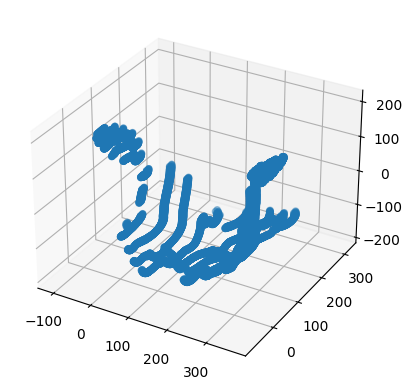

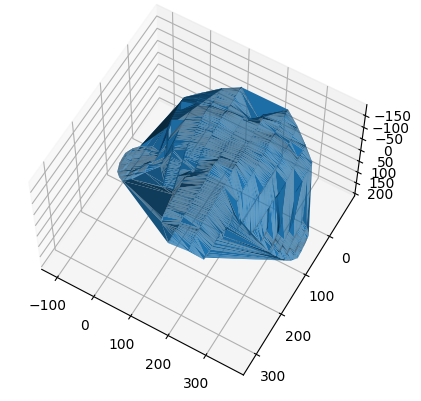

In [48]:
def plot_3d_points(points):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x = points[0]
    y = points[1]
    z = points[2]
    ax.scatter3D(x, y, z)
    plt.show()

def plot_3d_figure(points):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x = points[0]
    y = points[1]
    z = points[2]
    ax.plot_trisurf(x, y, z)
    ax.view_init(elev=-120, azim=-120)
    plt.show()


plot_3d_points(point)
plot_3d_figure(point)
 

In [35]:
# J AI ABONDONNE DE RECTIFIER LES IMAGES 

#Etape 2

# 1. For each pixel in first image find corresponding epipolar line in second images
# 2. Examine all corresponding pixels on epipolar line and pick best match
# 3. Triangulate matches to get depth information

#Stereo rectification : on met les deux caméra à même "hauteur" => leur epilines vont coincider == scanlines
#Step 1 : Find projective transformation HLeft and HRight (3x3) such that epipoles e and e' are mapped to the infinite point [1,0,0]^T

print(imgSize) 
rectifyScale = 0
rectRotLeft, rectRotRight, rectProjLeft, rectProjRight, Q, roi1, roi2 = cv.stereoRectify(cameraMatrixL, distL, cameraMatrixR, distR, imgSize, rotMatrix, transMatrix, rectifyScale, (0,0))

mapLeft1, mapLeft2 = cv.initUndistortRectifyMap(cameraMatrixL, distL, rectRotLeft, rectProjLeft, imgSize, cv.CV_32FC1)
mapRight1, mapRight2 = cv.initUndistortRectifyMap(cameraMatrixR, distR, rectRotRight, rectProjRight, imgSize, cv.CV_32FC1)

#Load images
imagesLeft = glob.glob('scanLeft/*.png')
imagesRight = glob.glob('scanRight/*.png')

#remap images
def remap(imagesLeft, mapLeft1, mapLeft2, imagesRight, mapRight1, mapRight2):
    remapLeft = []
    remapRight = []
    for i in range(len(imagesLeft)):
        imgL = cv.imread(imagesLeft[i])
        imgR = cv.imread(imagesRight[i])
        remapLeft.append(cv.remap(imgL, mapLeft1, mapLeft2, cv.INTER_LINEAR))
        remapRight.append(cv.remap(imgR, mapRight1, mapRight2, cv.INTER_LINEAR))
        
    return remapLeft, remapRight

remapLeft, remapRight = remap(imagesLeft, mapLeft1, mapLeft2, imagesRight, mapRight1, mapRight2)

def displayImagesRectified(remapLeft, remapRight):
    for i in range(len(remapLeft)):
        # cv.resize(remapLeft[i], (1920*2,1080*2), fx=0.0, fy=0.0)
        # cv.resize(remapRight[i], (1920*2,1080*2), fx=0.0, fy=0.0)
        cv.imshow('rectifiedLeft', remapLeft[i])
        cv.imshow('rectifiedRight', remapRight[i])
        cv.waitKey(0)
        cv.destroyAllWindows()

def saveImagesRectified(remapLeft, remapRight):
    for i in range(len(remapLeft)):
        cv.imwrite('savedImages/rectifiedLeft/'+str(i)+'.png', remapLeft[i])
        cv.imwrite('savedImages/rectifiedRight/'+str(i)+'.png', remapRight[i])

# displayImagesRectified(remapLeft, remapRight)
saveImagesRectified(remapLeft, remapRight)

(1920, 1080)


In [16]:
#Etape 3
#Draw epipolar lines
def getEpiline(remapLeft, remapRight, fundamentalMatrix):
    for i in range(len(remapLeft)):
        imgL = remapLeft[i]
        imgR = remapRight[i]
        #Find epipolar lines
        linesRight = cv.computeCorrespondEpilines(imgL.reshape(-1,1,2), 1, fundamentalMatrix)
        linesRight = linesRight.reshape(-1,3)
        #Draw lines
        imgR = cv.cvtColor(imgR, cv.COLOR_GRAY2BGR)
        for x1,y1,x2,y2 in linesRight:
            cv.line(imgR, (x1,y1), (x2,y2), (0,255,0), 1)
        cv.imshow('rectifiedRight', imgR)
        cv.waitKey(0)
        cv.destroyAllWindows()
# drawEpipolarLines(remapLeft, remapRight, fundamentalMatrix)

def correspondanceSearch(method, imageLeftPixels, imageRightPixels):
    #NCC
    if method == 'NCC':
        #NCC
        #Find best match
        bestMatch = []
        for i in range(len(imageLeftPixels)):
            #Find best match
            bestMatch.append(np.argmax(np.correlate(imageLeftPixels[i], imageRightPixels[i])))
        return bestMatch
    #SSD
    elif method == 'SSD':
        #SSD
        #Find best match
        bestMatch = []
        for i in range(len(imageLeftPixels)):
            #Find best match
            bestMatch.append(np.argmin(np.sum((imageLeftPixels[i] - imageRightPixels[i])**2, axis=1)))
        return bestMatch
    #SAD
    elif method == 'SAD':
        #SAD
        #Find best match
        bestMatch = []
        for i in range(len(imageLeftPixels)):
            #Find best match
            bestMatch.append(np.argmin(np.sum(np.abs(imageLeftPixels[i] - imageRightPixels[i]), axis=1)))
        return bestMatch

def depthFromDisparity(disparity,focalLengthX, baseline):
    #Depth from disparity
    #Disparity = x-x' => on doit savoir quel x correspond à quel x' avec bestMatch
    depth = []
    for i in range(len(disparity)):
        depth.append((focalLengthX * baseline) / disparity[i])
    return depth

